## Import Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
import cv2
import joblib
import seaborn as sns
import tensorflow as tf
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
plt.rcParams['figure.figsize']= (20,8)

In [2]:
labels = ['emergency', 'non_emergency']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('./train')
test = get_training_data('./test')

C:\Users\kabee\AppData\Local\Temp\ipykernel_1088\2031249520.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

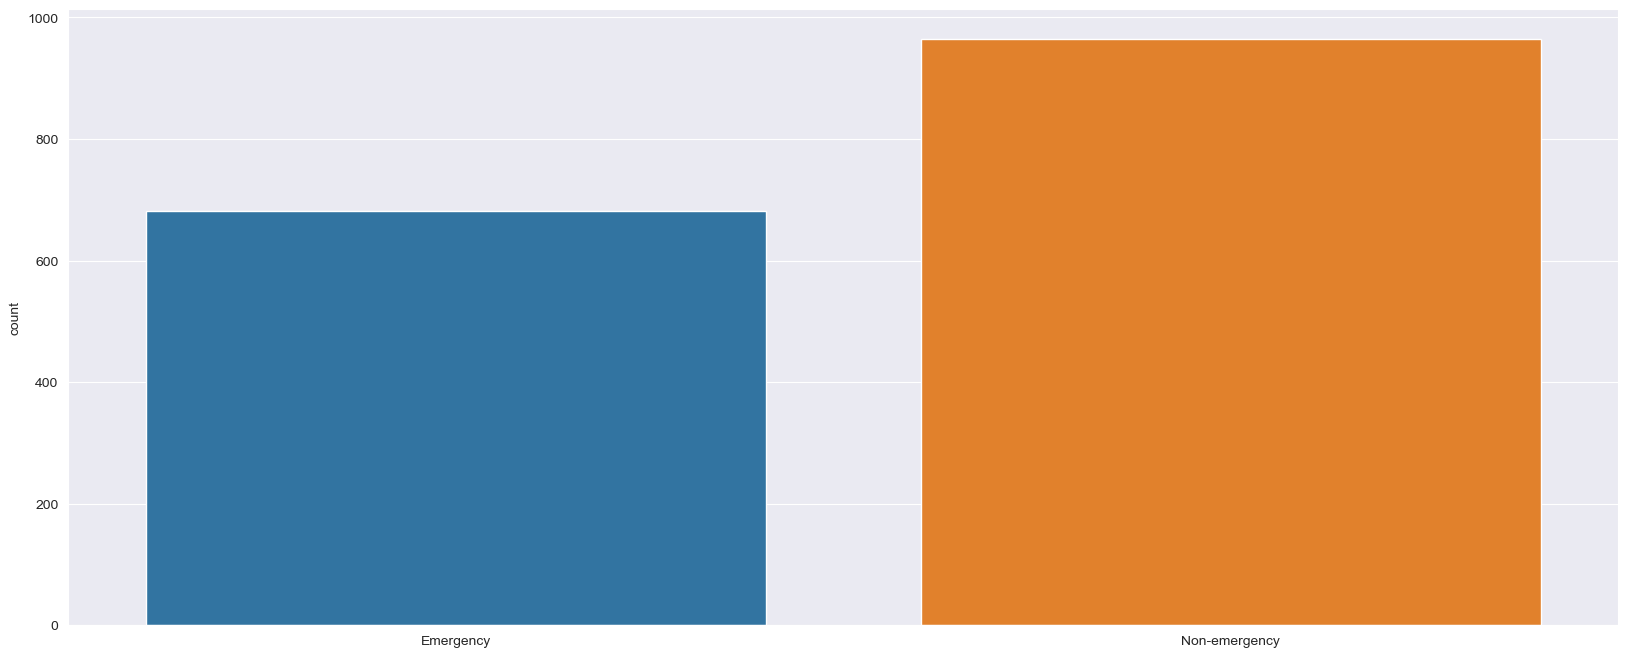

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Emergency")
    else:
        l.append("Non-emergency")
sns.set_style('darkgrid')
sns.countplot(l)   

Text(0.5, 1.0, 'non_emergency')

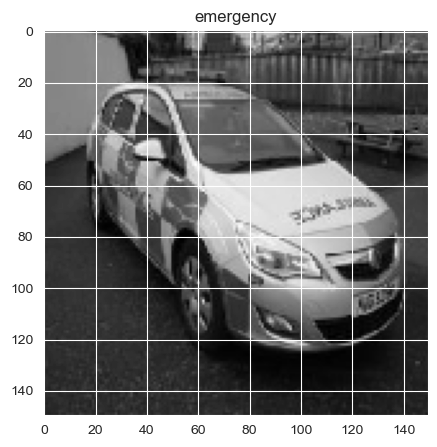

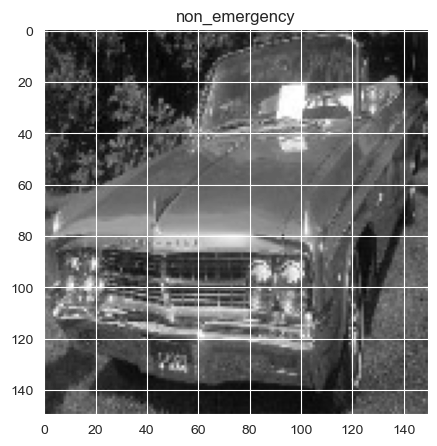

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
img_size = 150
batch_size= 32

train_datagen = ImageDataGenerator(rescale=1/255.,
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True)  # randomly flip images

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('./train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                 
                                                    shuffle = True,
                                                    class_mode ='binary')

val_generator = val_datagen.flow_from_directory('./val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                
                                                shuffle = False,
                                                class_mode ='binary')

test_generator = test_datagen.flow_from_directory('./test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                
                                                shuffle = False,
                                                class_mode ='binary')

Found 1646 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 680 images belonging to 2 classes.


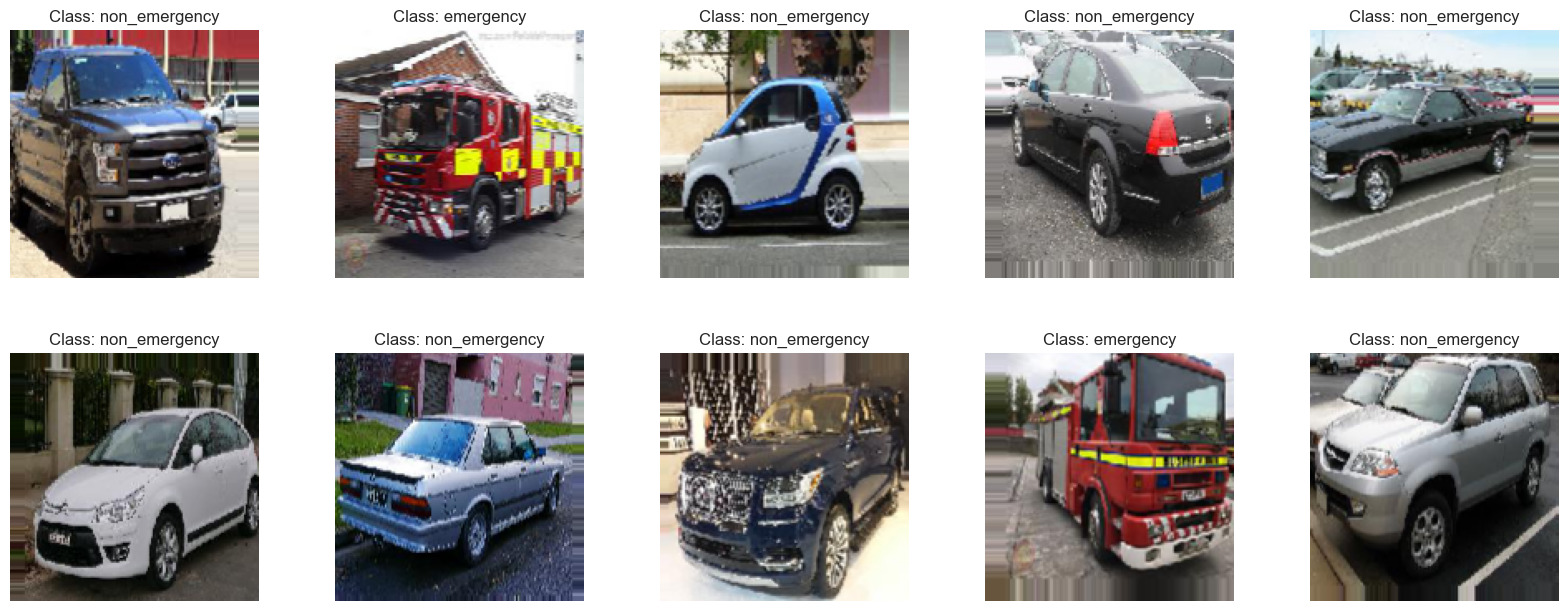

In [8]:
labels = ['emergency', 'non_emergency']

samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i] )
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [9]:
# Part 2 - Building the CNN

# Initialising the CNN
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))


cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath= "model_cnn"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
    

In [12]:
history = cnn.fit(train_generator, validation_data= val_generator,
                    epochs = 20, callbacks= [checkpoint])

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.6367 - recall: 0.8466
Epoch 1: val_loss improved from inf to 0.53533, saving model to model_cnn


INFO:tensorflow:Assets written to: model_cnn\assets


INFO:tensorflow:Assets written to: model_cnn\assets


52/52 [==============================] - 30s 534ms/step - loss: 0.6399 - accuracy: 0.6367 - recall: 0.8466 - val_loss: 0.5353 - val_accuracy: 0.6538 - val_recall: 0.8000
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7485 - recall: 0.8352
Epoch 2: val_loss improved from 0.53533 to 0.48799, saving model to model_cnn


INFO:tensorflow:Assets written to: model_cnn\assets


INFO:tensorflow:Assets written to: model_cnn\assets


52/52 [==============================] - 24s 464ms/step - loss: 0.5194 - accuracy: 0.7485 - recall: 0.8352 - val_loss: 0.4880 - val_accuracy: 0.7692 - val_recall: 0.8000
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.7667 - recall: 0.8487
Epoch 3: val_loss improved from 0.48799 to 0.46758, saving model to model_cnn


INFO:tensorflow:Assets written to: model_cnn\assets


INFO:tensorflow:Assets written to: model_cnn\assets


52/52 [==============================] - 25s 486ms/step - loss: 0.4873 - accuracy: 0.7667 - recall: 0.8487 - val_loss: 0.4676 - val_accuracy: 0.6923 - val_recall: 0.8000
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.7995 - recall: 0.8788
Epoch 4: val_loss improved from 0.46758 to 0.44907, saving model to model_cnn


INFO:tensorflow:Assets written to: model_cnn\assets


INFO:tensorflow:Assets written to: model_cnn\assets


52/52 [==============================] - 25s 475ms/step - loss: 0.4431 - accuracy: 0.7995 - recall: 0.8788 - val_loss: 0.4491 - val_accuracy: 0.7308 - val_recall: 0.8000
Epoch 5/20
52/52 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.7934 - recall: 0.8663
Epoch 5: val_loss did not improve from 0.44907
52/52 [==============================] - 26s 491ms/step - loss: 0.4245 - accuracy: 0.7934 - recall: 0.8663 - val_loss: 0.4645 - val_accuracy: 0.7692 - val_recall: 0.8667
Epoch 6/20
52/52 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8262 - recall: 0.8995
Epoch 6: val_loss did not improve from 0.44907
52/52 [==============================] - 23s 436ms/step - loss: 0.3913 - accuracy: 0.8262 - recall: 0.8995 - val_loss: 0.5508 - val_accuracy: 0.7692 - val_recall: 0.9333
Epoch 7/20
52/52 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8311 - recall: 0.8922
Epoch 7: val_loss did not improve from 0.44907
52/52 [=========

In [13]:
history_df = pd.DataFrame(history.history)
history_df 

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.639916,0.636695,0.846632,0.535332,0.653846,0.800000
1,0.519388,0.748481,0.835233,0.487991,0.769231,0.800000
2,0.487305,0.766707,0.848705,0.467577,0.692308,0.800000
3,0.443129,0.799514,0.878756,0.449066,0.730769,0.800000
4,0.424474,0.793439,0.866321,0.464482,0.769231,0.866667
5,0.391289,0.826245,0.899482,0.550830,0.769231,0.933333
6,0.363663,0.831106,0.892228,0.472648,0.769231,0.933333
7,0.349935,0.843864,0.901554,0.628022,0.807692,1.000000
8,0.314327,0.863305,0.915026,0.518691,0.769231,0.933333
9,0.326700,0.863305,0.912953,0.504335,0.807692,0.933333


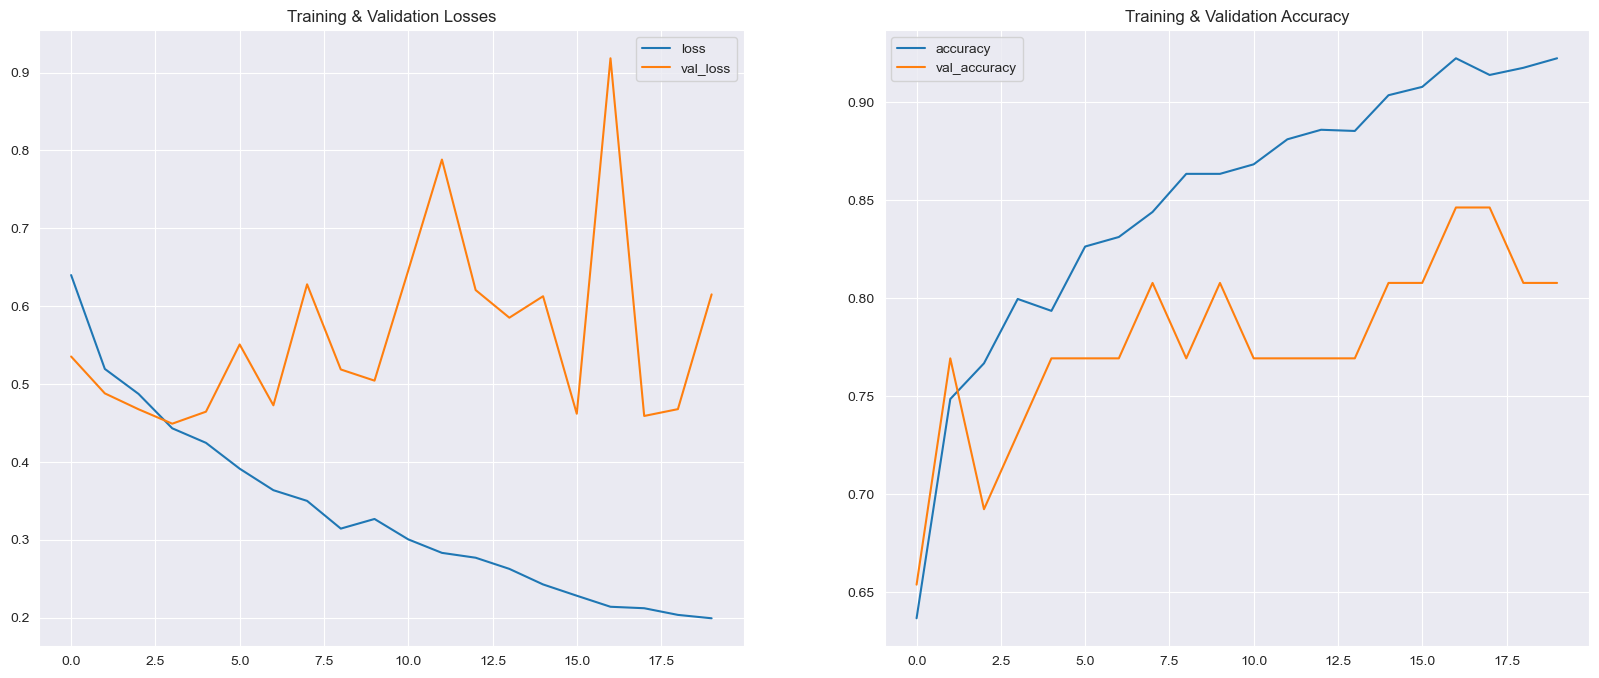

In [14]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)

In [15]:
classes = val_generator.classes
y_pred = cnn.predict(val_generator)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

1/1 [==============================] - 0s 348ms/step


In [16]:
print(classification_report(classes,y_pred,target_names=labels))

               precision    recall  f1-score   support

    emergency       0.88      0.64      0.74        11
non_emergency       0.78      0.93      0.85        15

     accuracy                           0.81        26
    macro avg       0.83      0.78      0.79        26
 weighted avg       0.82      0.81      0.80        26



In [17]:
acc = accuracy_score(classes,y_pred)
print(acc*100)

80.76923076923077


In [18]:
tester = cnn.evaluate(test_generator)

22/22 [==============================] - 2s 111ms/step - loss: 0.2824 - accuracy: 0.8809 - recall: 0.9528


In [19]:
print("Loss of the model is - " , cnn.evaluate(test_generator)[0])
print("Accuracy of the model is - " , cnn.evaluate(test_generator)[1]*100 , "%")

22/22 [==============================] - 2s 95ms/step - loss: 0.2824 - accuracy: 0.8809 - recall: 0.9528
Loss of the model is -  0.2823515832424164
22/22 [==============================] - 2s 94ms/step - loss: 0.2824 - accuracy: 0.8809 - recall: 0.9528
Accuracy of the model is -  88.08823823928833 %


In [20]:
from tensorflow.keras.models import load_model
from keras.models import load_model

In [24]:
cnn.save('emergency.h5')

In [30]:
keras.__version__

'2.12.0'